In [1]:
import os
import numpy as np
from gwpy.timeseries import TimeSeries, TimeSeriesDict
import matplotlib.pyplot as plt
from scipy import signal

/home/x-ctirapongpra/.local/lib/python3.9/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


- Scales by 10^-21
- Crops to first 4 seconds
- Adds 2s of zeros before and after (total duration now 8 seconds)
- Tapers with Tukey window
- Decimates to 4096 Hz

In [2]:
# Load h+ channel
data_dir = 'h(t)'
channel_name = 'GW:HP_X'
timeseries_dict = {}
t0_gps = 1000000000  # GPS start time (corresponds to Sept 2011)


# Load time and strain data
time_data = np.loadtxt(os.path.join(data_dir, 't.txt'), delimiter=',') # (comma-separated)
data = np.loadtxt(os.path.join(data_dir, 'hp_x.txt'))

# Calculate sample rate
dt = time_data[1] - time_data[0]
sample_rate = 1.0 / dt

ts = TimeSeries(data, sample_rate=sample_rate, t0=t0_gps, name=channel_name, unit='strain')

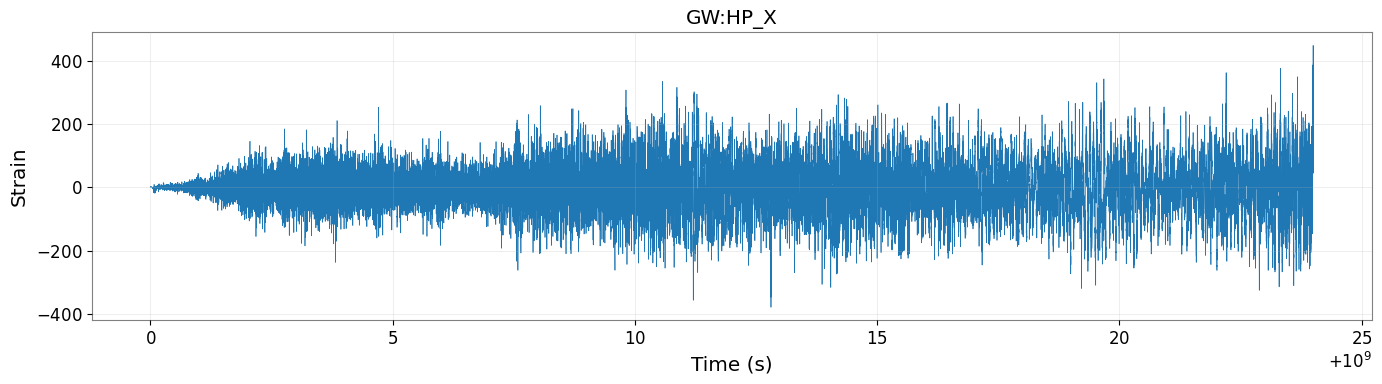

In [3]:
plt.figure(figsize=(14, 4))
plt.plot(ts.times.value, ts.value, linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title(channel_name)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# Preprocessing steps
ts_processed = ts * 1e-23 # scale
ts_processed = ts_processed.crop(t0_gps, t0_gps + 4.0) # crop to first 4 seconds

# Add 2 seconds of zeros before and after the signal
sample_rate_original = ts_processed.sample_rate.value
n_zeros = int(2.0 * sample_rate_original)  # 2 seconds of samples

# Create zero-padded data
padded_data = np.concatenate([np.zeros(n_zeros), ts_processed.value, np.zeros(n_zeros)])

# Create new TimeSeries with padded data (adjusting t0 to account for the 2s prepended)
ts_processed = TimeSeries(padded_data, sample_rate=sample_rate_original, 
                          t0=t0_gps - 2.0, name=channel_name, unit='strain')

# Apply taper to the entire padded signal
ts_processed = ts_processed * signal.windows.tukey(len(ts_processed), alpha=0.1)

# Decimate to 4096 Hz
decimation_factor = int(ts_processed.sample_rate.value / 4096)
data_decimated = signal.decimate(ts_processed.value, decimation_factor, ftype='iir')
ts_processed = TimeSeries(data_decimated, sample_rate=4096, t0=t0_gps - 2.0, name=channel_name, unit='strain')

# To write GWF format, first install: conda install -c conda-forge python-ldas-tools-framecpp            
ts_processed.write('Frame.gwf', format='gwf')
print(f"Written {len(ts_processed)} samples at {ts_processed.sample_rate.value} Hz to Frame.gwf")
print(f"Total duration: {ts_processed.duration.value} seconds (2s zeros + 4s signal + 2s zeros)")

Written 39996 samples at 4096.0 Hz to Frame.gwf
Total duration: 9.7646484375 seconds (2s zeros + 4s signal + 2s zeros)


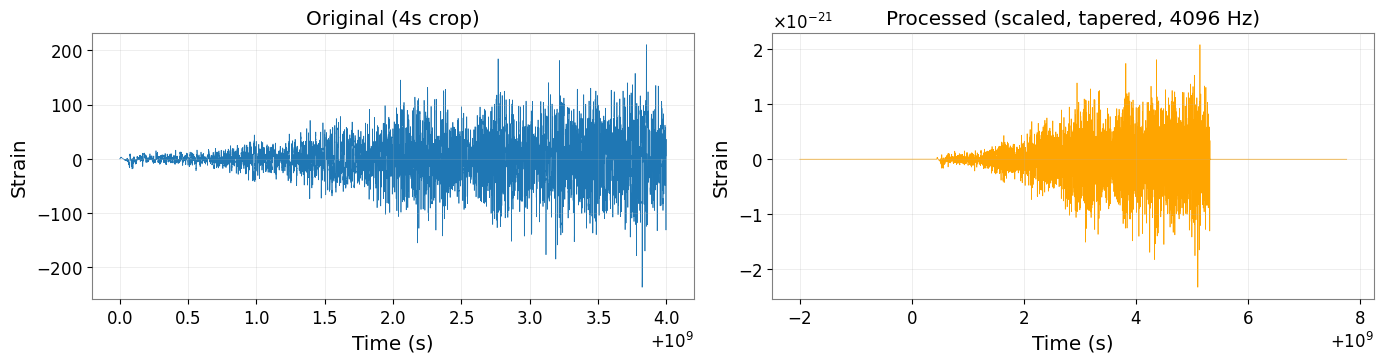

In [5]:
# Compare original vs processed
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(ts.crop(t0_gps, t0_gps + 4.0).times.value, ts.crop(t0_gps, t0_gps + 4.0).value, linewidth=0.5)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Strain')
axes[0].set_title('Original (4s crop)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(ts_processed.times.value, ts_processed.value, linewidth=0.5, color='orange')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Strain')
axes[1].set_title('Processed (scaled, tapered, 4096 Hz)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()